In [1]:
import gym
from gym import spaces
import numpy as np

class MazeEnv(gym.Env):
    def __init__(self):
        super(MazeEnv, self).__init__()
        # 定义迷宫大小
        self.size = 5  # 5x5 网格
        self.start = (0, 0)  # 起点
        self.goal = (4, 4)  # 终点
        self.current_position = self.start
        
        # 动作空间: 上(0), 下(1), 左(2), 右(3)
        self.action_space = spaces.Discrete(4)
        
        # 状态空间: 迷宫网格的二维坐标
        self.observation_space = spaces.Box(low=0, high=self.size-1, shape=(2,), dtype=np.int32)
        
        # 障碍物 (可以调整位置)
        self.obstacles = {(1, 1), (2, 2), (3, 3)}

    def reset(self):
        self.current_position = self.start
        return self.current_position

    def step(self, action):
        x, y = self.current_position
        if action == 0:  # 上
            x = max(0, x - 1)
        elif action == 1:  # 下
            x = min(self.size - 1, x + 1)
        elif action == 2:  # 左
            y = max(0, y - 1)
        elif action == 3:  # 右
            y = min(self.size - 1, y + 1)

        # 更新位置
        new_position = (x, y)
        if new_position in self.obstacles:
            new_position = self.current_position  # 碰到障碍物，原地不动

        self.current_position = new_position
        done = new_position == self.goal
        reward = 1 if done else -0.1  # 到达目标奖励 1，否则每步扣 0.1

        return new_position, reward, done, {}

    def render(self, mode='human'):
        maze = np.zeros((self.size, self.size), dtype=str)
        maze[:] = '.'
        for obs in self.obstacles:
            maze[obs] = '#'
        x, y = self.current_position
        maze[x, y] = 'A'
        gx, gy = self.goal
        maze[gx, gy] = 'G'
        print("\n".join(" ".join(row) for row in maze))


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Q网络定义
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# 经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)


In [3]:
def train_dqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=10000)

    epsilon = epsilon_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                states, actions, rewards_batch, next_states, dones = replay_buffer.sample(batch_size)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).max(1)[0]
                loss = nn.MSELoss()(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

import matplotlib.pyplot as plt

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs Episode')
    plt.show()


In [4]:
def test_dqn(env, q_net, num_episodes=5):
    q_net.eval() # 设置为评估模式
    env.reset()
    env.render()
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        print(f"Episode {episode + 1}")
        path = [state]
        while not done:
            with torch.no_grad():
                action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
            state, reward, done, _ = env.step(action)
            path.append(state)
            total_reward += reward
        print(f"Total Reward: {total_reward}")
        print(f"Path: {path}")


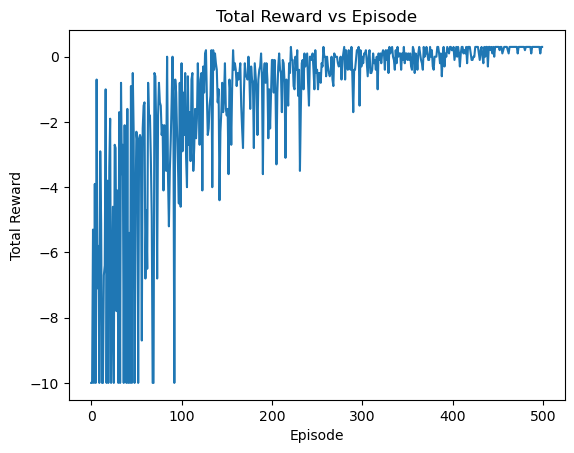

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]


In [5]:
if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewards = train_dqn(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)


In [6]:
def train_double_dqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=10000)

    epsilon = epsilon_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                states, actions, rewards_batch, next_states, dones = replay_buffer.sample(batch_size)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                loss = nn.MSELoss()(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards


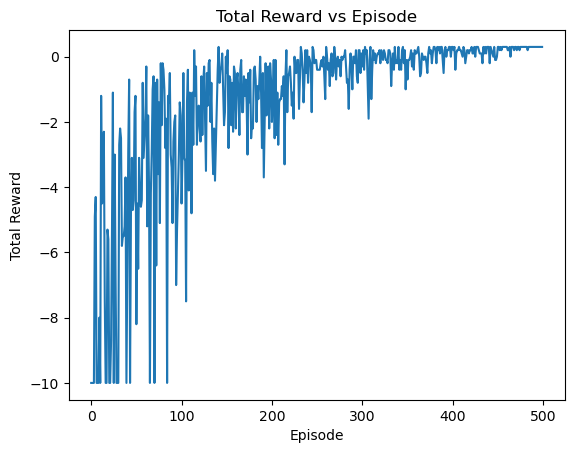

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]


In [7]:
if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewards = train_double_dqn(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)


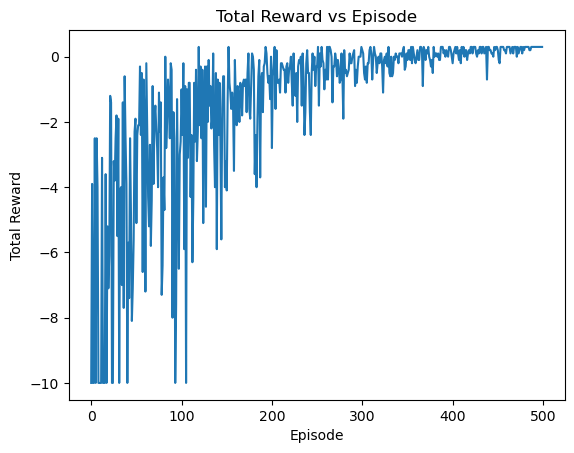

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


In [8]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

def train_dueling_dqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = DuelingDQN(input_dim, output_dim)
    target_net = DuelingDQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=10000)

    epsilon = epsilon_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                states, actions, rewards_batch, next_states, dones = replay_buffer.sample(batch_size)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                loss = nn.MSELoss()(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewards = train_dueling_dqn(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)


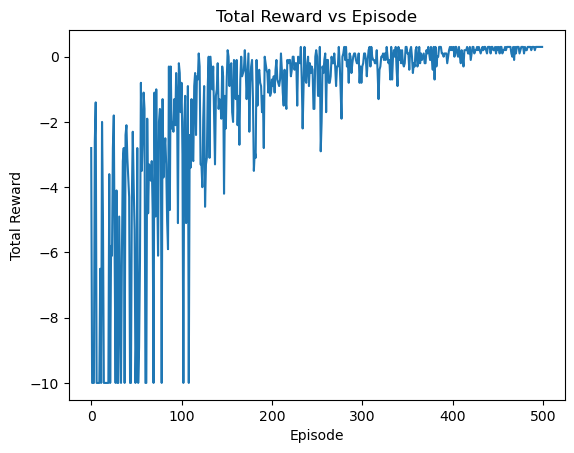

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]


In [9]:
import numpy as np

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        """添加新经验，优先级初始化为最大值以确保被采样"""
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        """
        采样带优先级的批次数据
        beta: 重要性采样的偏置修正参数
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities
    
    def size(self):
        return len(self.buffer)

def train_dueling_dqn_PER(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = DuelingDQN(input_dim, output_dim)
    target_net = DuelingDQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = PrioritizedReplayBuffer(capacity=10000, alpha=alpha)

    epsilon = epsilon_start
    beta = beta_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                # 计算 TD Error
                td_errors = target_q_values - q_values
                loss = (weights * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作
        # 更新 beta
        beta = min(1.0, beta + beta_increment)

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewards = train_dueling_dqn_PER(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)

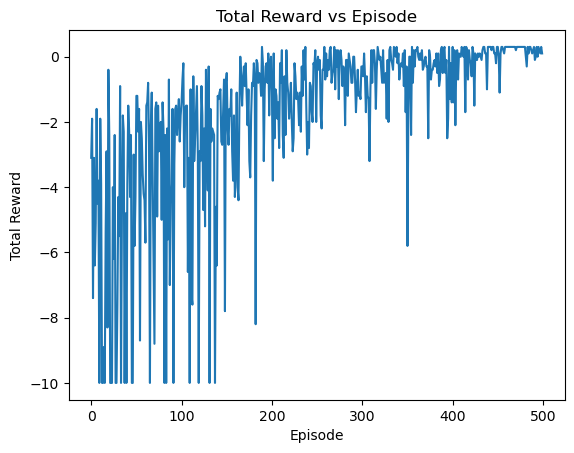

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


In [10]:
import torch
import torch.nn as nn

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        # 可训练参数
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # 非参数化噪声
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        # 初始化可训练参数
        bound = 1 / self.in_features ** 0.5
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))

    def reset_noise(self):
        # 采样噪声
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(x, weight, bias)

class Dueling_NoisyDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Dueling_NoisyDQN, self).__init__()
        self.fc = nn.Sequential(
            NoisyLinear(input_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, 128),
            nn.ReLU(),
        )
        self.V = NoisyLinear(128, 1)
        self.A = NoisyLinear(128, output_dim)

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q
    
    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

def train_dueling_dqn_noise_PER(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = Dueling_NoisyDQN(input_dim, output_dim)
    q_net.train() # 设置为训练模式，需要通过训练更新参数，该行代码可以省略，因为默认就是训练模式
    target_net = Dueling_NoisyDQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval() # 设置为评估模式，不需要通过训练更新参数，更新时只需要复制q_net的参数

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = PrioritizedReplayBuffer(capacity=10000, alpha=alpha)

    epsilon = epsilon_start
    beta = beta_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                # 计算 TD Error
                td_errors = target_q_values - q_values
                loss = (weights * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作
        # 更新 beta
        beta = min(1.0, beta + beta_increment)
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewards = train_dueling_dqn_noise_PER(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)

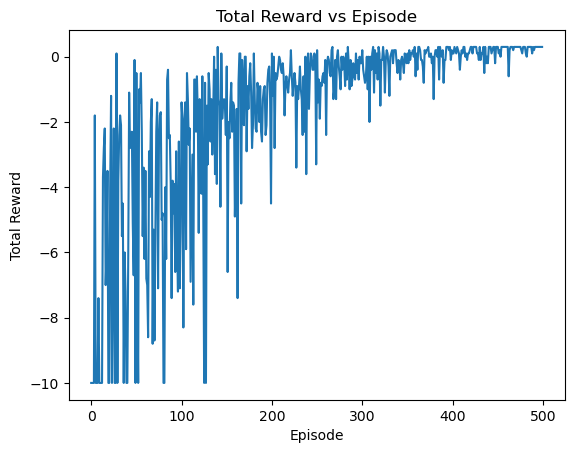

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]


In [11]:
class MultiStepPrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, n_step=3, gamma=0.99):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        n_step: 多步时间跨度
        gamma: 折扣因子
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha
        self.n_step = n_step
        self.gamma = gamma

        # 用于多步存储的临时队列
        self.n_step_queue = []

    def _get_n_step_info(self):
        """从 n_step_queue 计算 n 步累计奖励和目标状态"""
        R = 0
        for idx, (_, _, reward, _, _) in enumerate(self.n_step_queue):
            R += (self.gamma ** idx) * reward
        state, action, _, next_state, done = self.n_step_queue[0]
        final_next_state, final_done = self.n_step_queue[-1][3], self.n_step_queue[-1][4]
        return (state, action, R, final_next_state, final_done)

    def add(self, state, action, reward, next_state, done):
        """
        添加新经验。
        使用 n_step_queue 缓存多步数据，只有在积累到 n 步时才存入 buffer。
        在轨迹结束时处理剩余的队列。
        """
        self.n_step_queue.append((state, action, reward, next_state, done))
        
        # 如果 n_step_queue 满了，处理一个完整的 n-step 转移
        if len(self.n_step_queue) == self.n_step:
            n_step_transition = self._get_n_step_info()
            max_priority = self.priorities.max() if self.buffer else 1.0
            if len(self.buffer) < self.capacity:
                self.buffer.append(n_step_transition)
            else:
                self.buffer[self.position] = n_step_transition
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.capacity

            # 移除队列的第一个元素
            self.n_step_queue.pop(0)

        # 如果 done=True，处理剩余队列中的短步转移
        if done:
            while self.n_step_queue:
                n_step_transition = self._get_n_step_info()
                max_priority = self.priorities.max() if self.buffer else 1.0
                if len(self.buffer) < self.capacity:
                    self.buffer.append(n_step_transition)
                else:
                    self.buffer[self.position] = n_step_transition
                self.priorities[self.position] = max_priority
                self.position = (self.position + 1) % self.capacity

                # 移除队列的第一个元素
                self.n_step_queue.pop(0)

    def sample(self, batch_size, beta=0.4):
        """
        采样带优先级的批次数据。
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities

    def size(self):
        return len(self.buffer)

def train_dueling_dqn_noise_MultiStep_PER(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = Dueling_NoisyDQN(input_dim, output_dim)
    q_net.train() # 设置为训练模式，需要通过训练更新参数，该行代码可以省略，因为默认就是训练模式
    target_net = Dueling_NoisyDQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval() # 设置为评估模式，不需要通过训练更新参数，更新时只需要复制q_net的参数

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=10000, alpha=alpha, n_step=3, gamma=gamma)

    epsilon = epsilon_start
    beta = beta_start
    rewards = []  # 确保它是一个列表

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                # 计算 TD Error
                td_errors = target_q_values - q_values
                loss = (weights * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict()) # 每隔10个episode，将q_net的参数复制到target_net中

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)  # 确保 append 正常工作
        # 更新 beta
        beta = min(1.0, beta + beta_increment)
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

if __name__ == "__main__":
    env = MazeEnv()
    q_net,rewards = train_dueling_dqn_noise_MultiStep_PER(env)
    plot_rewards(rewards)
    test_dqn(env, q_net)

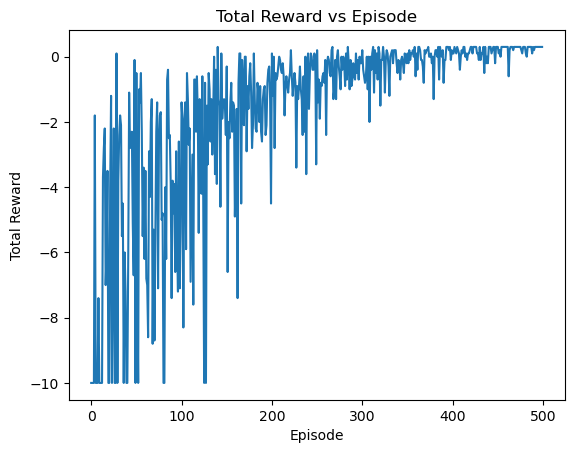

A . . . .
. # . . .
. . # . .
. . . # .
. . . . G
Episode 1
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 2
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 3
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 4
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Episode 5
Total Reward: 0.30000000000000004
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Dueling_DistributionalDQN(nn.Module):
    def __init__(self, input_dim, output_dim, num_atoms=51):
        super(Dueling_DistributionalDQN, self).__init__()
        self.fc = nn.Sequential(
            NoisyLinear(input_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, 128),
            nn.ReLU(),
        )
        self.V = NoisyLinear(128, num_atoms)
        self.A = NoisyLinear(128, output_dim * num_atoms)
        self.num_atoms = num_atoms
        self.output_dim = output_dim

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x).view(-1, 1, self.num_atoms)
        A = self.A(x).view(-1, self.output_dim, self.num_atoms)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        Q_prob = F.softmax(Q, dim=2) # 将 Q 值转换为概率分布
        return Q_prob

    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

def projection_distribution(next_dist, rewards, dones, gamma, atoms, v_min, v_max, delta_z, support):
    """
    投影 Bellman 更新后的分布到支持点。
    """
    #delta_z = (v_max - v_min) / (atoms - 1)
    #support = torch.linspace(v_min, v_max, atoms).to(next_dist.device)  # Shape: (atoms,)
    
    batch_size = rewards.size(0)
    next_support = rewards.unsqueeze(1) + gamma * support.unsqueeze(0) * (1 - dones.unsqueeze(1))  # Shape: (batch_size, atoms)
    next_support = next_support.clamp(v_min, v_max)  # 限制范围

    b = (next_support - v_min) / delta_z  # Shape: (batch_size, atoms)
    l = b.floor().long()  # Shape: (batch_size, atoms)
    u = b.ceil().long()  # Shape: (batch_size, atoms)
    
    # 修正索引的范围，确保不越界
    l = l.clamp(0, atoms - 1)
    u = u.clamp(0, atoms - 1)
    
    proj_dist = torch.zeros(batch_size, atoms).to(next_dist.device)  # Shape: (batch_size, atoms)

    for i in range(atoms):  # 遍历每个支持点
        # 注意：next_dist[:, i] 实际是 batch_size 的第 i 列 (shape: [batch_size])
        # next_dist 应被广播以匹配 l 和 u 的维度
        weight_left = (u[:, i] - b[:, i]).unsqueeze(1)  # Shape: (batch_size, 1)
        weight_right = (b[:, i] - l[:, i]).unsqueeze(1)  # Shape: (batch_size, 1)
        
        proj_dist.scatter_add_(1, l[:, i].unsqueeze(1), next_dist[:, i].unsqueeze(1) * weight_left)
        proj_dist.scatter_add_(1, u[:, i].unsqueeze(1), next_dist[:, i].unsqueeze(1) * weight_right)

    # 归一化分布
    proj_dist /= proj_dist.sum(dim=1, keepdim=True) + 1e-8  # 防止除零
    return proj_dist

def train_rainbow_dqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01,
                      epsilon_decay=500, lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4,
                      atoms=51, v_min=-10, v_max=10):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = Dueling_DistributionalDQN(input_dim, output_dim, num_atoms=atoms)
    target_net = Dueling_DistributionalDQN(input_dim, output_dim, num_atoms=atoms)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=10000, alpha=alpha, n_step=3, gamma=gamma)

    epsilon = epsilon_start
    beta = beta_start
    delta_z = (v_max - v_min) / (atoms - 1)
    rewards = []
    supports = torch.linspace(v_min, v_max, atoms)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    dist = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                    action = (dist * supports).sum(dim=2).argmax().item()

            # 执行动作
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta)

                # 计算 Q 网络的分布
                dist = q_net(states)
                q_dist = dist[range(batch_size), actions]

                # 目标分布计算
                with torch.no_grad():
                    # 目标网络输出分布
                    next_dist = target_net(next_states)  # Shape: (batch_size, num_actions, atoms)
                    # 行为网络选择动作（Double-DQN）
                    next_q_values = (q_net(next_states) * supports.to(next_states.device)).sum(dim=2)  # Shape: (batch_size, num_actions)
                    next_actions = next_q_values.argmax(dim=1)  # Shape: (batch_size,)
                    # 根据行为网络选择的动作提取目标分布
                    next_dist = next_dist[range(batch_size), next_actions]  # Shape: (batch_size, atoms)

                    # 投影分布
                    target_dist = projection_distribution(next_dist, rewards_batch, dones, gamma, atoms, v_min, v_max, delta_z, supports.to(next_states.device))

                # KL 散度损失
                loss = -(target_dist * q_dist.log()).sum(dim=1) * weights
                loss = loss.mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                # Wasserstein 距离计算
                td_errors = torch.sum((target_dist - q_dist) * supports.to(next_states.device), dim=1)  # [batch_size]
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)
        # 更新 beta
        beta = min(1.0, beta + beta_increment)
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()

        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return q_net, rewards

def test_rainbow_dqn(env, q_net, num_episodes=5, atoms=51, v_min=-3.0, v_max=1.0):
    q_net.eval() # 设置为评估模式
    env.reset()
    env.render()
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        print(f"Episode {episode + 1}")
        path = [state]
        while not done:
            with torch.no_grad():
                dist = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action = (dist * torch.linspace(v_min, v_max, atoms)).sum(dim=2).argmax().item()
            state, reward, done, _ = env.step(action)
            path.append(state)
            total_reward += reward
        print(f"Total Reward: {total_reward}")
        print(f"Path: {path}")

if __name__ == "__main__":
    env = MazeEnv()
    q_net, rewwards = train_rainbow_dqn(env, atoms=51, v_min=-3.0, v_max=1.0)
    plot_rewards(rewards)
    test_rainbow_dqn(env, q_net, num_episodes=5, atoms=51, v_min=-3.0, v_max=1.0)
